In [7]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter
from skimage.draw import disk
import time
from skimage.measure import label, regionprops
import diplib as dip

from GetEvent import GetEvent

DIPlib -- a quantitative image analysis library
Version 3.6.0 (Oct 23 2025)
For more information see https://diplib.org


In [4]:
ll = ['cam','run_control']

TEST_RUN='/exp/e961/app/users/alkucich/LAr10Ana/nb/MyAna/HoughStough/Data/20260120_1'
TEST_EVT = 3 #1, 3, 4, 5, 6(?), 7, 8(?), 9,

ev = GetEvent(TEST_RUN, TEST_EVT,*ll)

3
0.02278612118073537


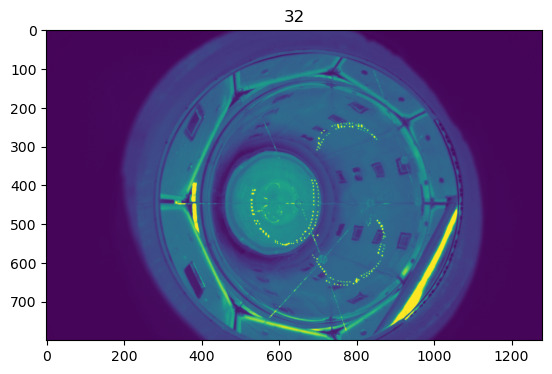

3
0.03137254901960784


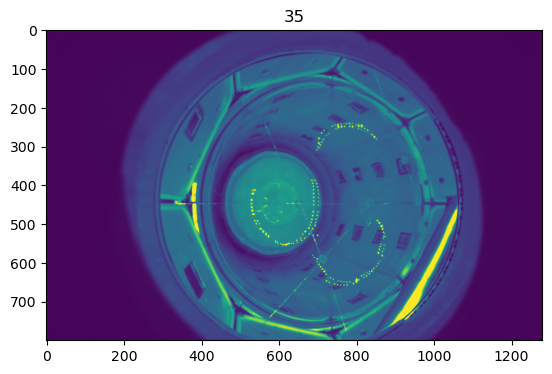

CPU times: user 4.42 s, sys: 7.84 ms, total: 4.43 s
Wall time: 3.57 s


In [17]:
%%time

cam = 3

#tunable params
num_pix_in_neighborhood = 10
diff_thresh = 0.02
noise_thresh = 10

#initialize dict and some variables that get incremented
bub_dict = {}
num_bubs = 0
cht_time = 0

#get mask for bubble region based on camera
Im = np.float32(np.average(ev['cam'][f'c{cam}']['frame0'],axis=2))
imShape = Im.shape
if cam==1:
    circy, circx = disk((375, 590), 300, shape=imShape)
    coord_mask = 2.1*circx-1375<circy
    mask_circx = circx[coord_mask]
    mask_circy = circy[coord_mask]
elif cam==2:
    mask_circy, mask_circx = disk((420, 660), 310, shape=imShape)
elif cam==3:
    mask_circy, mask_circx = disk((450, 680), 310, shape=imShape)

#get number of frames in event
keys = ev['cam'][f'c{cam}'].keys()
frames = 0
for key in keys:
    if 'frame' in key:
        frames+=1

bubs_found = False
first_bub = True

for i in range(frames-1):

    im_num = i+1
    
    #stop 5 frames after we first see a bubble
    if first_bub==False and i>stop_frame:
        break
       
    #get successive images
    thisIm = np.float32(np.average(ev['cam'][f'c{cam}'][f'frame{i}'],axis=2))
    nextIm = np.float32(np.average(ev['cam'][f'c{cam}'][f'frame{im_num}'],axis=2)) #may have to be changed later to account for missing frames
    Tshape = thisIm.T.shape
    
    #get diff and mask out noise
    preMask_diff = abs(thisIm-nextIm)
    preMask_diff[preMask_diff<noise_thresh] = 0
    
    #apply mask to isolate bubble region depending on which camera we're viewing from
    diff = np.zeros((imShape[0],imShape[1]))
    diff[mask_circy,mask_circx] = preMask_diff[mask_circy,mask_circx]
    diff-=dip.GetSinglePixels(diff > 0)

    #estimate radius by finding largest region by area in binary diff
    bindiff = diff>0
    labeled = label(bindiff)
    props = regionprops(labeled)
    largest_region = max(props, key = lambda prop: prop.area)
    est_rad = np.round(np.sqrt(largest_region.area)) 

    #perform CHT
    if est_rad<3:
        continue
    elif est_rad==3:
        min_rad = est_rad
    else:
        min_rad = est_rad-2
    max_rad = min_rad+2
    rad_cands = np.int32(np.arange(min_rad,max_rad,1))

    ####################
    start = time.time()
    ####################
    
    for rad in rad_cands:
        circx, circy = circle_perimeter(600, 400, rad, shape=Tshape)
        dx = circx-600
        dy = circy-400
        offsets = [(dx[i],dy[i]) for i in range(len(dx))]

        this_layer = np.zeros((imShape[0],imShape[1]))
        for offset in offsets:
            this_layer += np.roll(diff,offset,(0,1))

        if rad==rad_cands[0]:
            accum = this_layer
        else:
            accum = np.dstack((accum,this_layer))

    ############################
    cht_time+=time.time()-start
    ############################

    #enter candidate loop
    vals_in_bub = 100
    vals_in_diff = np.sum(diff.ravel())
    prev_coords = np.array([])
    prev_rad = 100
    
    while vals_in_bub>=diff_thresh:
        #get leading candidate
        peak_cand = np.where(accum==np.max(accum)) #replace with argmax
        cx = peak_cand[1][0]
        cy = peak_cand[0][0]
        rad = rad_cands[peak_cand[2]][0]

        #see what fraction of total diff values is contained inside the bubble
        circy, circx = disk((cy, cx), rad, shape=imShape)
        vals_in_bub = np.sum(diff[circy,circx])/vals_in_diff

        #if candidate passes thresh, save bubble info
        if vals_in_bub>=diff_thresh:
            
            bubs_found = True
            if first_bub==True:
                stop_frame = im_num+5
                if stop_frame>=frames:
                    stop_frame = frames
                first_bub = False
                
            if prev_rad!=100:
                if rad>prev_rad+1 or rad<prev_rad-1:
                    #bubbles in same frame won't differ that dramatically in size; 
                    #eliminates false tags around small bubbles
                    break

            #if there's any overlap between this and previous bubble, exit candidate loop
            #otherwise, go ahead and save bubble info
            circy, circx = disk((cy, cx), rad+num_pix_in_neighborhood, shape=imShape)
            bub_coords = np.array([(circx[i],circy[i]) for i in range(len(circx))])
            if bub_coords.any() in prev_coords:
                break
            else:
                this_bub_dict = {}
                this_bub_dict['Pos'] = (np.uint32(cx),np.uint32(cy))
                this_bub_dict['Radius'] = rad
                this_bub_dict['Significance'] = vals_in_bub
                this_bub_dict['Frame'] = im_num
                this_bub_dict['Cam'] = cam
                bub_dict[f'Bubble{num_bubs}'] = this_bub_dict
                num_bubs+=1
                prev_coords = bub_coords
                prev_rad = rad

            ##########################################################
            
            for i in range(3):
                show_circx, show_circy = circle_perimeter(cx, cy, rad+i, shape=imShape)
                nextIm[show_circy,show_circx] = 100
            plt.imshow(nextIm)
            plt.title(f'{im_num}')
            print(rad)
            print(vals_in_bub)
            plt.show()
            
            ##########################################################

        #set this part of the accumulator array to zero to find next highest peak
        accum[circy,circx] = 0

In [18]:
print(cht_time)
print(bub_dict)

0.3468611240386963
{'Bubble0': {'Pos': (np.uint32(810), np.uint32(376)), 'Radius': np.int32(3), 'Significance': np.float64(0.02278612118073537), 'Frame': 32, 'Cam': 3}, 'Bubble1': {'Pos': (np.uint32(811), np.uint32(376)), 'Radius': np.int32(3), 'Significance': np.float64(0.03137254901960784), 'Frame': 35, 'Cam': 3}}
